# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [130]:
# import libraries
from pyspark.sql import SparkSession, Window
from pyspark.sql.functions import avg, col, concat, desc, explode, lit, min, max, split, udf
from pyspark.sql.functions import sum as Fsum
from pyspark.sql.types import IntegerType, StringType, FloatType
from pyspark.ml import Pipeline

from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, GBTClassifier
from pyspark.ml.feature import CountVectorizer, StandardScaler, StringIndexer, VectorAssembler, OneHotEncoder
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

import re
import datetime
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [131]:
# create a Spark session
spark = SparkSession.builder\
                    .appName('Sparkify')\
                    .getOrCreate()

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [132]:
data = 'mini_sparkify_event_data.json'

df = spark.read.json(data)
df.persist()

DataFrame[artist: string, auth: string, firstName: string, gender: string, itemInSession: bigint, lastName: string, length: double, level: string, location: string, method: string, page: string, registration: bigint, sessionId: bigint, song: string, status: bigint, ts: bigint, userAgent: string, userId: string]

In [133]:
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [134]:
# how many rows are there in the dataset
df.count()

286500

In [135]:
# show stasistics
df.describe().show()

# show atcounts of each column
df.describe().show(1, vertical=True)

+-------+------------------+----------+---------+------+------------------+--------+-----------------+------+-----------------+------+-------+--------------------+-----------------+--------------------+------------------+--------------------+--------------------+-----------------+
|summary|            artist|      auth|firstName|gender|     itemInSession|lastName|           length| level|         location|method|   page|        registration|        sessionId|                song|            status|                  ts|           userAgent|           userId|
+-------+------------------+----------+---------+------+------------------+--------+-----------------+------+-----------------+------+-------+--------------------+-----------------+--------------------+------------------+--------------------+--------------------+-----------------+
|  count|            228108|    286500|   278154|278154|            286500|  278154|           228108|286500|           278154|286500| 286500|            

In [136]:
# Inspect unique available userIds
df.select('userId').dropDuplicates().sort('userId').show()

+------+
|userId|
+------+
|      |
|    10|
|   100|
|100001|
|100002|
|100003|
|100004|
|100005|
|100006|
|100007|
|100008|
|100009|
|100010|
|100011|
|100012|
|100013|
|100014|
|100015|
|100016|
|100017|
+------+
only showing top 20 rows



In [137]:
df.select('userId').groupby(df.userId).count().sort('userId').show()


+------+-----+
|userId|count|
+------+-----+
|      | 8346|
|    10|  795|
|   100| 3214|
|100001|  187|
|100002|  218|
|100003|   78|
|100004| 1245|
|100005|  216|
|100006|   44|
|100007|  520|
|100008|  940|
|100009|  671|
|100010|  381|
|100011|   23|
|100012|  600|
|100013| 1392|
|100014|  310|
|100015| 1050|
|100016|  638|
|100017|   75|
+------+-----+
only showing top 20 rows



In [138]:
# exploring missing values in columns
df.filter(df["firstName"].isNull()).select("page").distinct().show()

+-------------------+
|               page|
+-------------------+
|               Home|
|              About|
|Submit Registration|
|              Login|
|           Register|
|               Help|
|              Error|
+-------------------+



In [139]:
# dropping rows that contain null values for userId and sessionId
df_valid = df.dropna(how="any", subset=["userId","sessionId"])

In [140]:
# now let's take a look at number of rows
df_valid.count()

286500

We can notice that the number of rows are the same . It is due to missing userId is represented using empty string.

In [141]:
df_valid.filter(df["userId"]=="").select("page").distinct().show()

+-------------------+
|               page|
+-------------------+
|               Home|
|              About|
|Submit Registration|
|              Login|
|           Register|
|               Help|
|              Error|
+-------------------+



In [142]:
df_valid = df_valid.filter(df_valid["userId"] != "")
df_valid.count()

278154

# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

In [143]:
df_valid.select('page').dropDuplicates().sort('page').show()

+--------------------+
|                page|
+--------------------+
|               About|
|          Add Friend|
|     Add to Playlist|
|              Cancel|
|Cancellation Conf...|
|           Downgrade|
|               Error|
|                Help|
|                Home|
|              Logout|
|            NextSong|
|         Roll Advert|
|       Save Settings|
|            Settings|
|    Submit Downgrade|
|      Submit Upgrade|
|         Thumbs Down|
|           Thumbs Up|
|             Upgrade|
+--------------------+



In [144]:
# Create a udf function to identify churn by flagging an event 
# with the "Cancellation Confirmation" page
is_churned = udf(lambda x: 1 if x == "Cancellation Confirmation" else 0, IntegerType())

# Add a new column 'isChurned' by passing a value in the 'page' column to the udf function
# created above (is_churned)
df_valid = df.withColumn("churned", churn("page"))

# Then, inspect the data
df_valid.head()

Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30', churned=0)

In [146]:
# adjusting timestamp to proper understandable format
convert_time = udf(lambda x : datetime.datetime.utcfromtimestamp(x/1000).strftime('%Y-%m-%d %H:%M:%S'))

# creating columns with the new timestamp format
df_valid = df_valid.withColumn('datetime', convert_time(df_valid.ts))
df_valid = df_valid.withColumn('registration_time', convert_time('registration'))

In [147]:
# percent of churned users
df_valid.filter(df_valid['churned']==1).select('userId').distinct().count()/df_valid.select('userId')\
        .distinct().count() * 100

23.008849557522122

In [148]:

# percent of non-churned users
df_valid.filter(df_valid['churned']==0).select('userId').distinct().count()/df_valid.select('userId').distinct().count() * 100

100.0

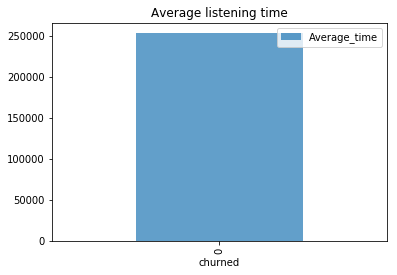

In [149]:
f1 = df_valid.where(df_valid["page"] == "NextSong").select("userId","churned","length")\
                        .groupby("userId","churned").agg({"length":"sum"})\
                        .groupby("churned")\
                        .agg({"sum(length)":"avg"})\
                        .withColumnRenamed("avg(sum(length))", "Average_time").toPandas()
f1.plot(kind='bar', y='Average_time', x='churned',title="Average listening time", alpha=0.7)

# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

In [162]:
# Fit with the train data
print('[{}] Start'.format(datetime.datetime.now()))
print('[{}] Done'.format(datetime.datetime.now()))

[2020-04-24 21:46:11.545101] Start
[2020-04-24 21:46:11.545866] Done


In [150]:
gender_idx = StringIndexer(inputCol="gender", outputCol='gender_idx')
page_idx = StringIndexer(inputCol="page", outputCol='page_idx')
gender_encoder = OneHotEncoder(inputCol='gender_idx', outputCol='gender_vec')
page_encoder = OneHotEncoder(inputCol='page_idx', outputCol='page_vec')
assembler = VectorAssembler(inputCols=["gender_vec", "page_vec", "status"], outputCol="features")
idx = StringIndexer(inputCol="churn", outputCol="label")

# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

In [152]:
train, test = df_final.randomSplit([0.8, 0.2], seed=42)

In [158]:
# Create an object
lr =  LogisticRegression()

# create a pipeline
pipeline = Pipeline(stages=[lr])

In [159]:
# Then, create a ParamGridBuilder
paramGrid = ParamGridBuilder() \
    .addGrid(lr.elasticNetParam,[0.0, 0.5, 1.0]) \
    .addGrid(lr.regParam,[0.0, 0.01, 0.1]) \
    .build()

# And use pipeline and paramGrid to construct a CrossValidator object
crossval = CrossValidator(estimator=pipeline,
                          estimatorParamMaps=paramGrid,
                          evaluator=BinaryClassificationEvaluator(),
                          numFolds=3)

## Summary
In the last section, we use Spark to create Machine Learning models from the LogisticRegression and GBTClassifier in conjunction with CrossValidator and ParamGridBuilder to tune hyper parameters to find the best model.

Based on the results above, we can see the the best model that we got from the GBTClassifier out perform the best model getting from the LogisticRegression in terms of accuracy and area under ROC but we spent more time to train the GBTClassifier model.

## What could be done to improve?
Although helper functions were created to perform common feature engineering tasks, the feature engineering steps in this project were performed using procedure programming and we would need to reimplement the same logic again for a similar task. Creating a class or utilizing a pipeline to perform the common data engineering process will greatly help and this also ease a process of using the same code when deploying in different environments as well (e.g. local, AWS, IBM etc.)

The data we used to train a Machine Learning model to predict churn is a tiny subset of the actual dataset (128MB) and it only contains a smaller number of users who are churned. We might see a different patterns or having a different performance metrics if the Machine Learning model is trained with a large dataset (12GB)

# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.

#### All done